In [ ]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
from pathlib import Path
from utils.mlflow_query import MlflowHelper
from utils.percentiles import calculate_values_per_percentiles, calculate_accuracies_per_percentiles, plot_accuracies_per_percentiles

In [ ]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441")
mlflow_helper.query_runs(pkl_file=Path("mlflow_run_df.pkl"))

In [ ]:
percentile_names=[
    'avg_input_frequencies_percentile', 
    'median_input_frequencies_percentile', 
    'min_input_frequencies_percentile', 
    'p10_input_frequencies_percentile', 
    'unknown_inputs_percentile', 
    'output_frequency_percentile',
    'avg_input_frequencies_range', 
    'median_input_frequencies_range', 
    'min_input_frequencies_range', 
    'p10_input_frequencies_range', 
    'unknown_inputs_range', 
    "unclustered_inputs_percentile",
    "unclustered_inputs_perc_percentile",
    "clustered_inputs_percentile",
    "clustered_inputs_perc_percentile",
    "single_clustered_inputs_percentile",
    "single_clustered_inputs_perc_percentile",
    "single_clustered_inputs_clusterperc_percentile",
    "multi_clustered_inputs_percentile",
    "multi_clustered_inputs_perc_percentile",
    "multi_clustered_inputs_clusterperc_percentile",
    "avg_cluster_input_frequency_percentile",
    "median_cluster_input_frequency_percentile",
    "unclustered_inputs_range",
    "unclustered_inputs_perc_range",
    "clustered_inputs_range",
    "clustered_inputs_perc_range",
    "single_clustered_inputs_range",
    "single_clustered_inputs_perc_range",
    "single_clustered_inputs_clusterperc_range",
    "multi_clustered_inputs_range",
    "multi_clustered_inputs_perc_range",
    "multi_clustered_inputs_clusterperc_range",
    "avg_cluster_input_frequency_range",
    "median_cluster_input_frequency_range",
]

# Overall accuracy per percentiles

In [ ]:
# relevant_huawei_run_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False)
# huawei_value_df = calculate_values_per_percentiles(
#     relevant_run_df=relevant_huawei_run_df, 
#     num_percentiles=10,
#     percentile_names=[
#         (percentile_name, percentile_name.replace("_range", "").replace("_percentile", ""))
#         for percentile_name in percentile_names
#         if not "output_frequency" in percentile_name
#         and percentile_name.endswith("_percentile")
#     ],
#     cluster_threshold=0.5,
#     local_mlflow_dir=mlflow_helper.local_mlflow_dir)

In [11]:
rel_df_huawei_1 = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, valid_x_columns=["fine_log_cluster_template"])
accuracy_df_1 = calculate_accuracies_per_percentiles(
   relevant_run_df=rel_df_huawei_1, k=5, num_percentiles=10, num_input_percentiles=10,
   percentile_names=percentile_names,
   local_mlflow_dir=mlflow_helper.local_mlflow_dir)
accuracy_df_1.to_csv("accuracy_df_1.csv")
accuracy_df_huawei_1 = pd.read_csv("accuracy_df_1.csv")

Calculating accuracy@k per percentile:   0%|          | 0/150 [00:00<?, ?it/s]

No attention file for run 2ad4e2ee416647da9c56214e71ada97c in local MlFlow dir
No attention file for run 2ad4e2ee416647da9c56214e71ada97c in local MlFlow dir


Calculating accuracy@k per percentile:   1%|          | 1/150 [00:20<50:07, 20.19s/it]

No attention file for run c6dd242b7e15499fbc4973b9b57bc91a in local MlFlow dir
No attention file for run c6dd242b7e15499fbc4973b9b57bc91a in local MlFlow dir


Calculating accuracy@k per percentile:   5%|▌         | 8/150 [02:51<51:43, 21.85s/it]

No attention file for run cedcb12704024337be655224df40a9b3 in local MlFlow dir
No attention file for run cedcb12704024337be655224df40a9b3 in local MlFlow dir


Calculating accuracy@k per percentile:   6%|▌         | 9/150 [03:11<49:56, 21.25s/it]

No attention file for run 699ec67c859b4d0ebdf5786f64819bec in local MlFlow dir
No attention file for run 699ec67c859b4d0ebdf5786f64819bec in local MlFlow dir


Calculating accuracy@k per percentile:   8%|▊         | 12/150 [04:16<50:13, 21.84s/it]

No attention file for run 968cb6503a9d4e3e8be108d805675db0 in local MlFlow dir
No attention file for run 968cb6503a9d4e3e8be108d805675db0 in local MlFlow dir


Calculating accuracy@k per percentile:   9%|▊         | 13/150 [04:36<48:29, 21.23s/it]

No attention file for run 0e979a5ef72e46abb675fd128ee6ae16 in local MlFlow dir
No attention file for run 0e979a5ef72e46abb675fd128ee6ae16 in local MlFlow dir


Calculating accuracy@k per percentile:  10%|█         | 15/150 [05:17<47:10, 20.97s/it]

No attention file for run f5a68bb613184bb9bb0b2cc6da636f07 in local MlFlow dir
No attention file for run f5a68bb613184bb9bb0b2cc6da636f07 in local MlFlow dir


Calculating accuracy@k per percentile:  11%|█         | 16/150 [05:37<46:09, 20.67s/it]

No attention file for run cd8d88eff99f4ee695ec3e776505236c in local MlFlow dir
No attention file for run cd8d88eff99f4ee695ec3e776505236c in local MlFlow dir


Calculating accuracy@k per percentile:  14%|█▍        | 21/150 [07:26<46:58, 21.85s/it]

No attention file for run bb6b969847aa4171be55c2f95c86e847 in local MlFlow dir
No attention file for run bb6b969847aa4171be55c2f95c86e847 in local MlFlow dir


Calculating accuracy@k per percentile:  15%|█▍        | 22/150 [07:46<45:19, 21.25s/it]

No attention file for run ddc555568c284147b687361e04d23d01 in local MlFlow dir
No attention file for run ddc555568c284147b687361e04d23d01 in local MlFlow dir


Calculating accuracy@k per percentile:  15%|█▌        | 23/150 [08:06<44:04, 20.82s/it]

No attention file for run b04d8c593dac47028f162fd6aa661348 in local MlFlow dir
No attention file for run b04d8c593dac47028f162fd6aa661348 in local MlFlow dir


Calculating accuracy@k per percentile:  16%|█▌        | 24/150 [08:26<42:59, 20.47s/it]

No attention file for run ad700c97213143d0a8da63328f4804f5 in local MlFlow dir
No attention file for run ad700c97213143d0a8da63328f4804f5 in local MlFlow dir


Calculating accuracy@k per percentile:  18%|█▊        | 27/150 [09:28<42:42, 20.83s/it]

No attention file for run 1cfdf971bd1d4c48ae99ae3967b1ae9d in local MlFlow dir
No attention file for run 1cfdf971bd1d4c48ae99ae3967b1ae9d in local MlFlow dir


Calculating accuracy@k per percentile:  25%|██▍       | 37/150 [13:06<41:14, 21.90s/it]

No attention file for run 709e2e104725461daef8935e0de2bc73 in local MlFlow dir
No attention file for run 709e2e104725461daef8935e0de2bc73 in local MlFlow dir


Calculating accuracy@k per percentile:  27%|██▋       | 41/150 [14:32<39:36, 21.80s/it]

No attention file for run aad6cc1a566e4b2b83a9313acec2b9ec in local MlFlow dir
No attention file for run aad6cc1a566e4b2b83a9313acec2b9ec in local MlFlow dir


Calculating accuracy@k per percentile:  30%|███       | 45/150 [15:57<37:53, 21.66s/it]

No attention file for run 56966641a8e3456a85c9d8b3992988b9 in local MlFlow dir
No attention file for run 56966641a8e3456a85c9d8b3992988b9 in local MlFlow dir


Calculating accuracy@k per percentile:  31%|███       | 46/150 [16:16<36:27, 21.03s/it]

No attention file for run 52d1b1c7f4f6497b88c510018967ae80 in local MlFlow dir
No attention file for run 52d1b1c7f4f6497b88c510018967ae80 in local MlFlow dir


Calculating accuracy@k per percentile:  33%|███▎      | 49/150 [17:20<35:55, 21.34s/it]

No attention file for run 1ef10098ac544545b89edd3553963fb6 in local MlFlow dir
No attention file for run 1ef10098ac544545b89edd3553963fb6 in local MlFlow dir


Calculating accuracy@k per percentile:  34%|███▍      | 51/150 [18:01<34:37, 20.99s/it]

No attention file for run 80e0c05a329d4e4ebb1ddbeb30f60e32 in local MlFlow dir
No attention file for run 80e0c05a329d4e4ebb1ddbeb30f60e32 in local MlFlow dir


Calculating accuracy@k per percentile:  35%|███▍      | 52/150 [18:21<33:37, 20.59s/it]

No attention file for run 3783f3066e4444da9fa8b9ef2be5e1a9 in local MlFlow dir
No attention file for run 3783f3066e4444da9fa8b9ef2be5e1a9 in local MlFlow dir


Calculating accuracy@k per percentile:  35%|███▌      | 53/150 [18:41<32:59, 20.41s/it]

No attention file for run 4f905f21d73741bb87556458e7638651 in local MlFlow dir
No attention file for run 4f905f21d73741bb87556458e7638651 in local MlFlow dir


Calculating accuracy@k per percentile:  37%|███▋      | 56/150 [19:46<33:39, 21.48s/it]

No attention file for run 97ae9a87a4f248c28a8ab21d9186e7f6 in local MlFlow dir
No attention file for run 97ae9a87a4f248c28a8ab21d9186e7f6 in local MlFlow dir


Calculating accuracy@k per percentile:  39%|███▊      | 58/150 [20:27<32:18, 21.07s/it]

No attention file for run cc7d273c3f224ea293c25b4b71a7ff6c in local MlFlow dir
No attention file for run cc7d273c3f224ea293c25b4b71a7ff6c in local MlFlow dir


Calculating accuracy@k per percentile:  41%|████      | 61/150 [21:31<31:28, 21.22s/it]

No attention file for run 57a5a9368a5c46b38bad41f5df914166 in local MlFlow dir
No attention file for run 57a5a9368a5c46b38bad41f5df914166 in local MlFlow dir


Calculating accuracy@k per percentile:  43%|████▎     | 64/150 [22:36<31:13, 21.78s/it]

No attention file for run c1e88f1d378a44b99580d092bbeddb45 in local MlFlow dir
No attention file for run c1e88f1d378a44b99580d092bbeddb45 in local MlFlow dir


Calculating accuracy@k per percentile:  48%|████▊     | 72/150 [25:30<28:33, 21.96s/it]

No attention file for run 3e0b8bca9f184e1394ae28e281c40468 in local MlFlow dir
No attention file for run 3e0b8bca9f184e1394ae28e281c40468 in local MlFlow dir


Calculating accuracy@k per percentile:  49%|████▊     | 73/150 [25:49<27:24, 21.36s/it]

No attention file for run d3df75bc51e24e97986d33578e03d590 in local MlFlow dir
No attention file for run d3df75bc51e24e97986d33578e03d590 in local MlFlow dir


Calculating accuracy@k per percentile:  50%|█████     | 75/150 [26:30<26:13, 20.98s/it]

No attention file for run c399b27a72bd4b4ebc8c11e22172e81c in local MlFlow dir
No attention file for run c399b27a72bd4b4ebc8c11e22172e81c in local MlFlow dir


Calculating accuracy@k per percentile:  55%|█████▌    | 83/150 [29:26<24:52, 22.27s/it]

No attention file for run b87f6823cc9b4158856bf15bc9cc8580 in local MlFlow dir
No attention file for run b87f6823cc9b4158856bf15bc9cc8580 in local MlFlow dir


Calculating accuracy@k per percentile:  56%|█████▌    | 84/150 [29:46<23:43, 21.57s/it]

No attention file for run 8339a11819fd465982c746c9032607a5 in local MlFlow dir
No attention file for run 8339a11819fd465982c746c9032607a5 in local MlFlow dir


Calculating accuracy@k per percentile:  62%|██████▏   | 93/150 [32:59<20:29, 21.56s/it]

No attention file for run b6e96fdb656b4e469ff4c134c1671485 in local MlFlow dir
No attention file for run b6e96fdb656b4e469ff4c134c1671485 in local MlFlow dir


Calculating accuracy@k per percentile:  63%|██████▎   | 94/150 [33:19<19:35, 21.00s/it]

No attention file for run e166d1542106420fbf32c117a6b1de81 in local MlFlow dir
No attention file for run e166d1542106420fbf32c117a6b1de81 in local MlFlow dir


Calculating accuracy@k per percentile:  68%|██████▊   | 102/150 [36:12<17:22, 21.72s/it]

No attention file for run f7843f3bbe9443b2b6bcd8d0337a08ea in local MlFlow dir
No attention file for run f7843f3bbe9443b2b6bcd8d0337a08ea in local MlFlow dir


Calculating accuracy@k per percentile:  73%|███████▎  | 109/150 [38:41<14:48, 21.68s/it]

No attention file for run c6160c4fd3e74d758387ad4a7b6c3ffe in local MlFlow dir
No attention file for run c6160c4fd3e74d758387ad4a7b6c3ffe in local MlFlow dir


Calculating accuracy@k per percentile:  76%|███████▌  | 114/150 [40:28<12:57, 21.59s/it]

No attention file for run d77a4221fa7c490ea0c54d193874d428 in local MlFlow dir
No attention file for run d77a4221fa7c490ea0c54d193874d428 in local MlFlow dir


Calculating accuracy@k per percentile:  77%|███████▋  | 115/150 [40:48<12:19, 21.14s/it]

No attention file for run e0d7df8b1d6642a4a9d55c24f1716e0b in local MlFlow dir
No attention file for run e0d7df8b1d6642a4a9d55c24f1716e0b in local MlFlow dir


Calculating accuracy@k per percentile:  78%|███████▊  | 117/150 [41:31<11:43, 21.31s/it]

No attention file for run 20aa34d4d9664811bbcfd9f1cfe416d2 in local MlFlow dir
No attention file for run 20aa34d4d9664811bbcfd9f1cfe416d2 in local MlFlow dir


Calculating accuracy@k per percentile:  79%|███████▊  | 118/150 [41:51<11:11, 20.98s/it]

No attention file for run dbd8d005ab024399821fddcc08a54c67 in local MlFlow dir
No attention file for run dbd8d005ab024399821fddcc08a54c67 in local MlFlow dir


Calculating accuracy@k per percentile:  81%|████████  | 121/150 [42:56<10:28, 21.66s/it]

No attention file for run 6df39d450a494b6ebc0384c74a6536cb in local MlFlow dir
No attention file for run 6df39d450a494b6ebc0384c74a6536cb in local MlFlow dir


Calculating accuracy@k per percentile:  83%|████████▎ | 124/150 [44:00<09:23, 21.67s/it]

No attention file for run 5b102d24e51a43e7a0ee7935573248bd in local MlFlow dir
No attention file for run 5b102d24e51a43e7a0ee7935573248bd in local MlFlow dir


Calculating accuracy@k per percentile:  84%|████████▍ | 126/150 [44:42<08:37, 21.56s/it]

No attention file for run a14eae9654cd4447abf0f49a75064373 in local MlFlow dir
No attention file for run a14eae9654cd4447abf0f49a75064373 in local MlFlow dir


Calculating accuracy@k per percentile:  85%|████████▍ | 127/150 [45:03<08:06, 21.15s/it]

No attention file for run 1883bb8d6e40488c98456347abd43fd1 in local MlFlow dir
No attention file for run 1883bb8d6e40488c98456347abd43fd1 in local MlFlow dir


Calculating accuracy@k per percentile:  85%|████████▌ | 128/150 [45:22<07:35, 20.71s/it]

No attention file for run 26fc9c55a97c4a0489b3cf0b525c09c2 in local MlFlow dir
No attention file for run 26fc9c55a97c4a0489b3cf0b525c09c2 in local MlFlow dir


Calculating accuracy@k per percentile:  87%|████████▋ | 131/150 [46:26<06:44, 21.27s/it]

No attention file for run e09e9e1ef1c84433b7fc72526695ba13 in local MlFlow dir
No attention file for run e09e9e1ef1c84433b7fc72526695ba13 in local MlFlow dir


Calculating accuracy@k per percentile:  89%|████████▉ | 134/150 [47:29<05:37, 21.08s/it]

No attention file for run b650ab08db134ea7a9cc1e2fce78bde5 in local MlFlow dir
No attention file for run b650ab08db134ea7a9cc1e2fce78bde5 in local MlFlow dir


Calculating accuracy@k per percentile:  90%|█████████ | 135/150 [47:49<05:11, 20.79s/it]

No attention file for run 6df6cd1286ec4c53a34ef80aa45e7cea in local MlFlow dir
No attention file for run 6df6cd1286ec4c53a34ef80aa45e7cea in local MlFlow dir


Calculating accuracy@k per percentile:  92%|█████████▏| 138/150 [48:54<04:19, 21.62s/it]

No attention file for run 931d910c902545bda3cb2e884bf31d67 in local MlFlow dir
No attention file for run 931d910c902545bda3cb2e884bf31d67 in local MlFlow dir


Calculating accuracy@k per percentile:  95%|█████████▌| 143/150 [50:43<02:35, 22.16s/it]

No attention file for run d1b36b52c0174d0d8c44d8f25f5c3946 in local MlFlow dir
No attention file for run d1b36b52c0174d0d8c44d8f25f5c3946 in local MlFlow dir


Calculating accuracy@k per percentile:  99%|█████████▊| 148/150 [52:30<00:43, 21.61s/it]

No attention file for run 6ea8d78d46e14a1eaf2f57d96ab94f6a in local MlFlow dir
No attention file for run 6ea8d78d46e14a1eaf2f57d96ab94f6a in local MlFlow dir


Calculating accuracy@k per percentile:  99%|█████████▉| 149/150 [52:50<00:21, 21.17s/it]

No attention file for run 1e41b6c780f04aaf936f2822ad595ad3 in local MlFlow dir
No attention file for run 1e41b6c780f04aaf936f2822ad595ad3 in local MlFlow dir


Calculating accuracy@k per percentile: 100%|██████████| 150/150 [53:10<00:00, 21.27s/it]


In [12]:
relevant_huawei_run_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False)
# huawei_accuracy_df = calculate_accuracies_per_percentiles(
#     relevant_run_df=relevant_huawei_run_df, k=5, num_percentiles=10, num_input_percentiles=10,
#     percentile_names=percentile_names,
#     local_mlflow_dir=mlflow_helper.local_mlflow_dir)

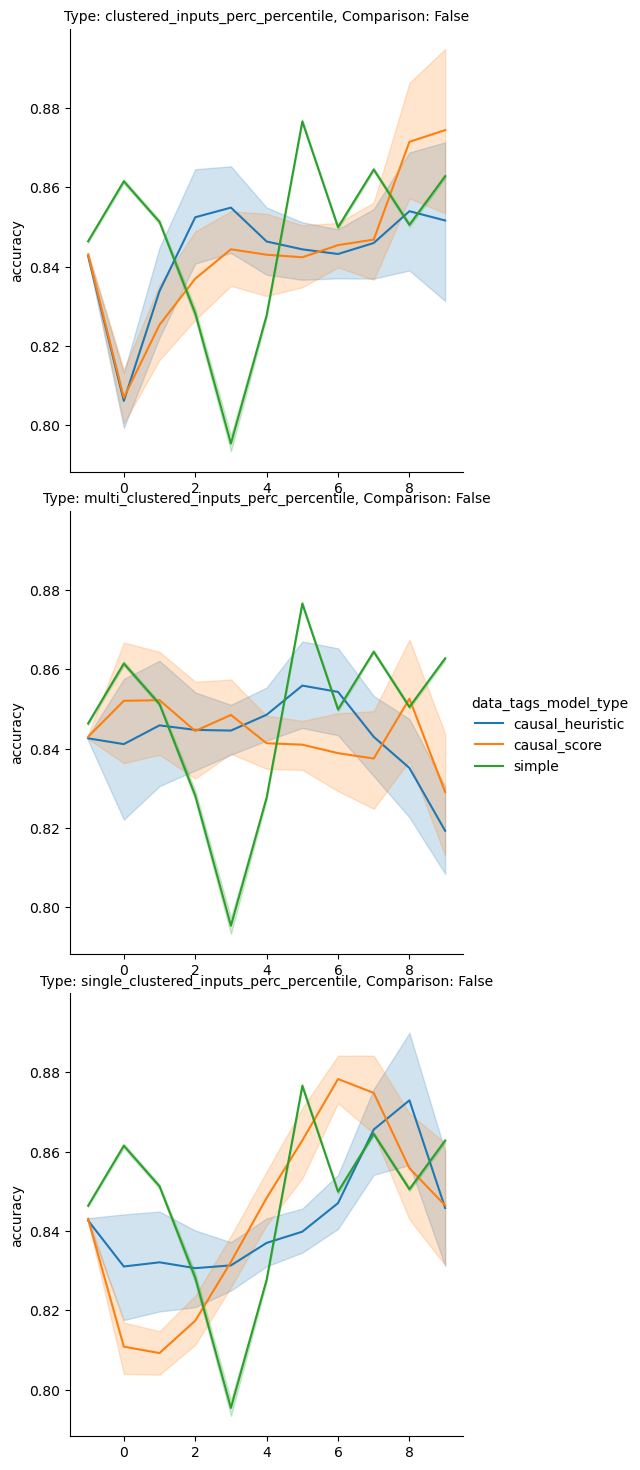

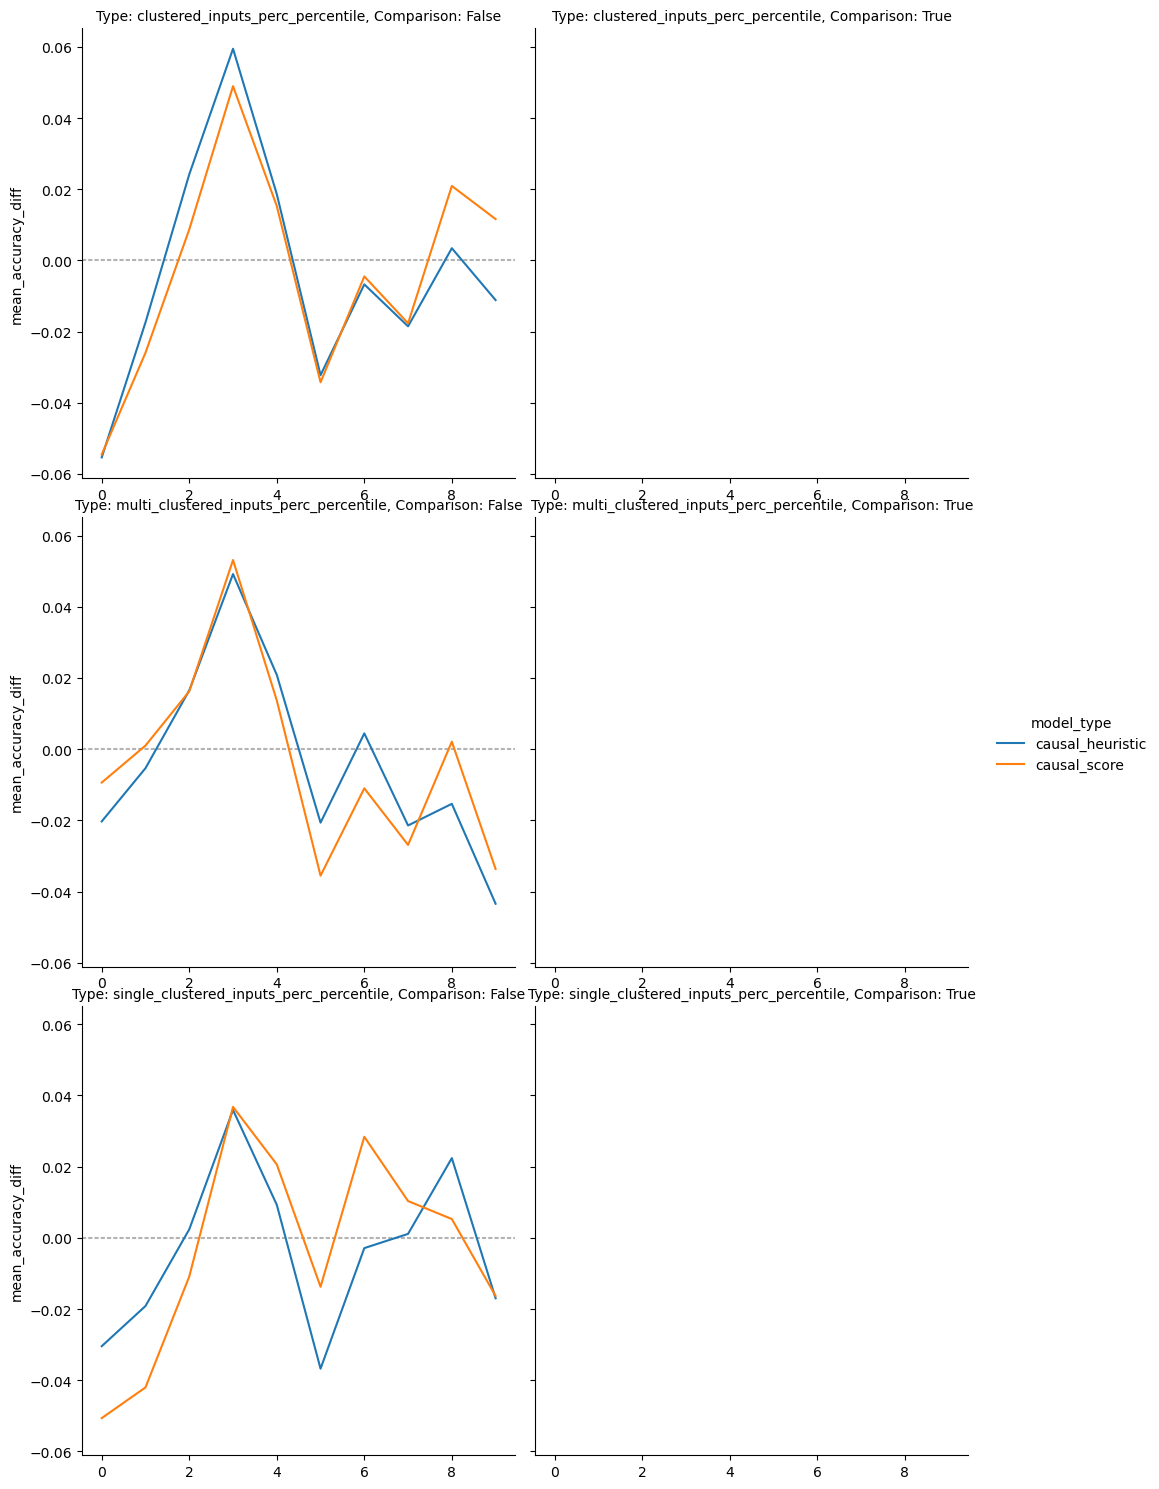

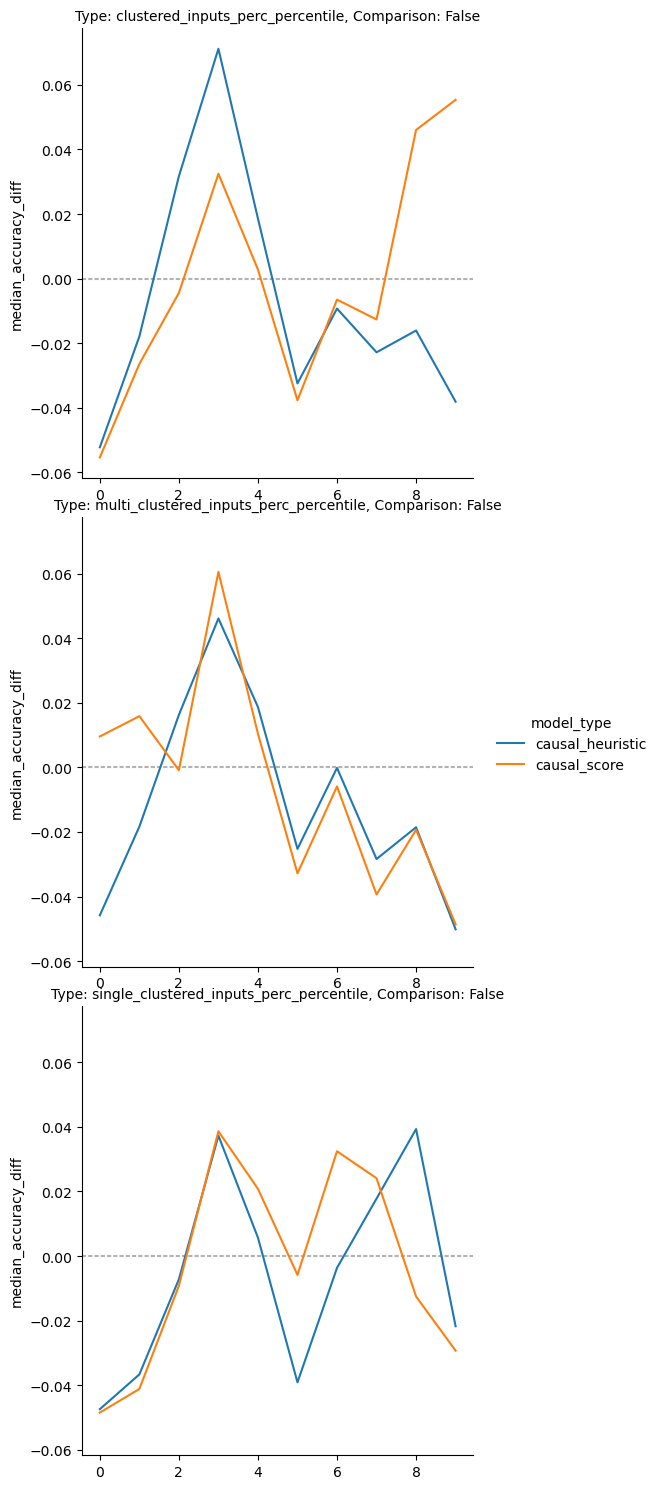

In [13]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_huawei_run_df, 
    accuracy_df=accuracy_df_huawei_1[
        accuracy_df_huawei_1["type"].apply(lambda x: x in [
            "clustered_inputs_perc_percentile",
            "single_clustered_inputs_perc_percentile",
            "multi_clustered_inputs_perc_percentile"
        ])    
    ],
    show_plot=True,
    share_y=True
)

# Accuracy@ for different input granularities

In [ ]:
merged_df = pd.merge(
    relevant_mimic_run_df2[
        relevant_mimic_run_df2["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], mimic_accuracy_df2[
        mimic_accuracy_df2["type"] == "output_frequency_percentile"
    ], left_on="info_run_id", right_on="run_id")
sns.catplot(
    data=merged_df,
    x="data_tags_model_type",
    order=["simple", "gram", "text", "causal"],
    y="accuracy",
    kind="box",
    row="percentile",
    col="data_params_SequenceConfigx_sequence_column_name",
    col_order=["level_0", "level_1", "level_2"],
    sharey="row",
).set_titles("Percentile: {row_name}, X = {col_name}").set_axis_labels(
    "", "accuracy"
)
plt.show()

In [ ]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_mimic_run_df2[
        relevant_mimic_run_df2["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], 
    accuracy_df=mimic_accuracy_df2[
        (mimic_accuracy_df2["type"] == "output_frequency_percentile")
        & (mimic_accuracy_df2["percentile"].astype(int) > -1)
    ],
    comparison_column="data_params_SequenceConfigx_sequence_column_name",
    comparison_column_order=["level_0", "level_1", "level_2"],
    show_plot=True,
    share_y=True)

In [ ]:
grouped_df = (
    pd.merge(
        relevant_mimic_run_df2[relevant_mimic_run_df2['data_tags_model_type'] != 'causal2'], 
        mimic_accuracy_df2[mimic_accuracy_df2['type'] == 'avg_input_frequencies_percentile'], left_on="info_run_id", right_on="run_id")
    .groupby(
        [
            "data_tags_model_type",
            "data_params_ModelConfigbase_hidden_embeddings_trainable",
            "data_params_SequenceConfigx_sequence_column_name",
            "info_run_id",
            "type",
            "percentile",
        ],
        as_index=False,
    )
    .agg({"accuracy": max,})
)
g = sns.relplot(
    data=grouped_df,
    x="percentile",
    y="accuracy",
    row="type",
    col="data_tags_model_type",
    hue="data_params_SequenceConfigx_sequence_column_name",
    style="data_params_ModelConfigbase_hidden_embeddings_trainable",
    kind="line",
    palette=None,
)
g.set_titles("Type: {row_name}, Model: {col_name}").set_axis_labels(
    "", "accuracy"
)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.show()

In [ ]:
relevant_huawei_run_df2 = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, 
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template"])
huawei_accuracy_df2 = calculate_accuracies_per_percentiles(
    relevant_run_df=relevant_huawei_run_df2, 
    k=5, num_percentiles=10, num_input_percentiles=10,
    percentile_names=percentile_names,
    local_mlflow_dir=mlflow_helper.local_mlflow_dir)

In [ ]:
plot_accuracies_per_percentiles(
    show_plot=False,
    relevant_run_df=relevant_huawei_run_df2[relevant_huawei_run_df2["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"], 
    accuracy_df=huawei_accuracy_df2[(huawei_accuracy_df2["type"] == "avg_input_frequencies_percentile") | (huawei_accuracy_df2["type"] == "unknown_inputs_percentile")],
    comparison_column="data_params_SequenceConfigx_sequence_column_name",
    comparison_column_order=["log_cluster_template", "coarse_log_cluster_template"],
    share_y=True)

In [ ]:
grouped_df = (
    pd.merge(
        relevant_huawei_run_df2[relevant_huawei_run_df2['data_tags_model_type'] != 'causal2'], 
        huawei_accuracy_df2[(huawei_accuracy_df2["type"] == "avg_input_frequencies_percentile") | (huawei_accuracy_df2["type"] == "unknown_inputs_percentile")],
        left_on="info_run_id", right_on="run_id")
    .groupby(
        [
            "data_tags_model_type",
            "data_params_ModelConfigbase_hidden_embeddings_trainable",
            "data_params_SequenceConfigx_sequence_column_name",
            "info_run_id",
            "type",
            "percentile",
        ],
        as_index=False,
    )
    .agg({"accuracy": max,})
)
g = sns.relplot(
    data=grouped_df,
    x="percentile",
    y="accuracy",
    row="type",
    col="data_tags_model_type",
    hue="data_params_SequenceConfigx_sequence_column_name",
    style="data_params_ModelConfigbase_hidden_embeddings_trainable",
    kind="line",
    palette=None,
)
g.set_titles("Type: {row_name}, Model: {col_name}").set_axis_labels(
    "", "accuracy"
)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.show()

In [ ]:
relevant_mimic_run_df.to_pickle("percentile_relevant_mimic_run_df.pkl")
relevant_huawei_run_df.to_pickle("percentile_relevant_huawei_run_df.pkl")
relevant_mimic_run_df2.to_pickle("percentile_relevant_mimic_run_df2.pkl")
relevant_huawei_run_df2.to_pickle("percentile_relevant_huawei_run_df2.pkl")

mimic_accuracy_df.to_pickle("percentile_mimic_accuracy_df.pkl")
mimic_accuracy_df2.to_pickle("percentile_mimic_accuracy_df2.pkl")
huawei_accuracy_df.to_pickle("percentile_huawei_accuracy_df.pkl")
huawei_accuracy_df2.to_pickle("percentile_huawei_accuracy_df2.pkl")

In [ ]:
relevant_mimic_run_df = pd.read_pickle("percentile_relevant_mimic_run_df.pkl")
relevant_huawei_run_df = pd.read_pickle("percentile_relevant_huawei_run_df.pkl")
relevant_mimic_run_df2 = pd.read_pickle("percentile_relevant_mimic_run_df2.pkl")
relevant_huawei_run_df2 = pd.read_pickle("percentile_relevant_huawei_run_df2.pkl")

mimic_accuracy_df = pd.read_pickle("percentile_mimic_accuracy_df.pkl")
mimic_accuracy_df2 = pd.read_pickle("percentile_mimic_accuracy_df2.pkl")
huawei_accuracy_df = pd.read_pickle("percentile_huawei_accuracy_df.pkl")
huawei_accuracy_df2 = pd.read_pickle("percentile_huawei_accuracy_df2.pkl")